# Linear regression of stock prices

In this note, linear regression is used to predict the stock closing price 
of the future using sklearn.

In [1]:
import datetime
import pickle

import numpy as np
import quandl
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Get stock data from quandl
df = quandl.get("WIKI/GOOGL")

# Create features
df["Hl_PCT"] = (df["Adj. High"] - df["Adj. Low"]) / df["Adj. Low"] * 100.0
df["PCT_change"] = (df["Adj. Close"] - df["Adj. Open"]) / df["Adj. Open"] * 100.0

# Subset dataframe
df = df[["Adj. Close", "Hl_PCT", "PCT_change", "Adj. Volume"]]

To predict the Adj. Close of the next $n$ days, the label 
column is defined as the Adj. Close column shifted up by $n$ rows. This model 
will use 0.1% of the dataset lenght as $n$.

In [3]:
# Create label column
forecast_col = "Adj. Close"
df.fillna(-99999, inplace=True)

# Number of days in the future to predict the close price
forecast_out = int(0.01*len(df))
print(forecast_out)
df["label"] = df[forecast_col].shift(-forecast_out)

34


The last $n=forecast\_out$ values of $X$ do not contain data due to the shift. 
These values will be stored in a separate variable. Next, the data is split 
into train and test.

In [4]:
# Split data in train (80%) and test (20%) data
X = np.array(df.drop(labels=["label"], axis=1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now can a LinearRegression model be trained. The resulting model is saved in
a pickle file.

In [5]:
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

with open ('linearregression.pickle', 'wb') as f:
	pickle.dump(clf, f)

In [6]:
accuracy = clf.score(X_test, y_test)
forecast_set = clf.predict(X_lately)

print(accuracy)

0.9783375129714387


In [7]:
# Plot the prediction of the LinearRegression model
df["Forecast"] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

<AxesSubplot:xlabel='Date'>

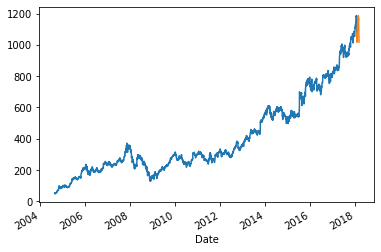

In [8]:
df["Adj. Close"].plot()
df["Forecast"].plot()

source: https://pythonprogramming.net/machine-learning-tutorial-python-introduction/